In [63]:
from PIL import Image
import numpy as np
import torch
import albumentations as A
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
import detect.tictactoeDetect as ttt
from matplotlib.patches import Rectangle

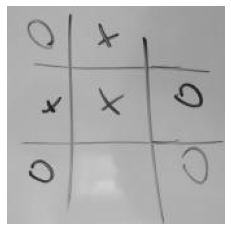

In [64]:
image = Image.open('data/boards/raw/0.jpg')
image = image.resize((168, 168), Image.ANTIALIAS)
fig, ax = plt.subplots(1)
plt.axis('off')
ax.imshow(image)

image = image.convert('L')

In [65]:
# transform = A.Compose([
#     A.InvertImg(p=0.18),
#     A.ColorJitter(brightness=0.55, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
#     A.GaussNoise(p=0.28),
#     A.Blur(blur_limit=4, p=0.22),
#     A.GlassBlur(max_delta=1, iterations=1, p=0.14),
#     A.CLAHE(p=0.3),
#     A.Sharpen(p=0.2),
#     A.Emboss(p=0.18),
#     A.Equalize(p=0.05),
#     A.MultiplicativeNoise(p=0.22),
# ])

# image1 = np.array(image)
# image1 = transform(image=image1)['image']
# plt.imshow(image1, cmap='gray')

In [66]:
def convert_cellboxes(predictions, S=6, C=9):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C+2*5)
    bboxes1 = predictions[..., C+1:C+5]
    bboxes2 = predictions[..., C+6:C+10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C+5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C+5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    return converted_preds

In [67]:
fieldModel = ttt.FieldModel()
fieldModel.load_state_dict(torch.load('detect/tictactoeField.pth', map_location='cpu'))
fieldModel.eval()
boardModel = ttt.BoardModel()
boardModel.load_state_dict(torch.load('detect/tictactoeBoard.pth', map_location='cpu'))
boardModel.eval()
print()

In [68]:
imageT = to_tensor(image).reshape(1, 1, 168, 168)
out = boardModel(imageT)

In [69]:
converted_pred = convert_cellboxes(out).reshape(out.shape[0], 36, -1)
converted_pred[..., 0] = converted_pred[..., 0].long()
fieldDict = {
    '0': torch.zeros((1, 28, 28)),
    '1': torch.zeros((1, 28, 28)),
    '2': torch.zeros((1, 28, 28)),
    '3': torch.zeros((1, 28, 28)),
    '4': torch.zeros((1, 28, 28)),
    '5': torch.zeros((1, 28, 28)),
    '6': torch.zeros((1, 28, 28)),
    '7': torch.zeros((1, 28, 28)),
    '8': torch.zeros((1, 28, 28)),
}

confidenceDict = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    '4': 0,
    '5': 0,
    '6': 0,
    '7': 0,
    '8': 0,
}

for bbox_idx in range(36):
    class_idx, confidence, x, y, w, h = [val.item() for val in converted_pred[0, bbox_idx, :]]
    if confidence > confidenceDict[str(int(class_idx))]:
        x = x * 168
        y = y * 168
        w = w * 168
        h = h * 168
        im1 = image.crop(
            (x - w / 2, y - h / 2, x + w / 2, y + h / 2)
        )
        im1 = im1.resize((28, 28))
        fieldDict[str(int(class_idx))] = to_tensor(im1)
        confidenceDict[str(int(class_idx))] = confidence
        rect = Rectangle(
            (x - w / 2, y - h / 2),
            x,
            y,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

fields = torch.stack(list(fieldDict.values()))
out = fieldModel(fields)
state = out.argmax(1).numpy().reshape(3, 3) - 1
print(state)
plt.show()


[[-1  1  0]
 [ 1  1 -1]
 [-1  0 -1]]


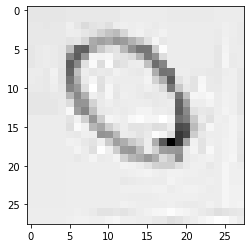

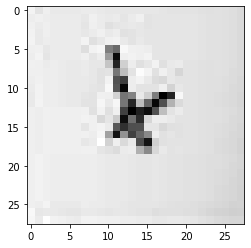

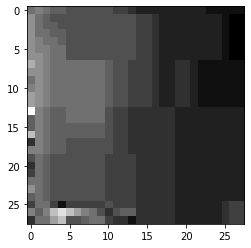

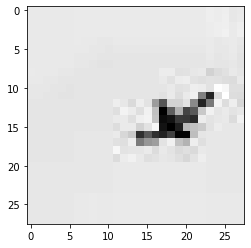

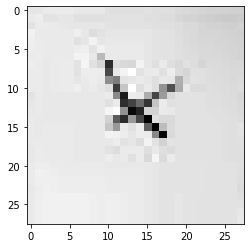

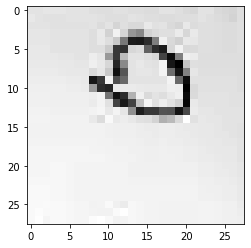

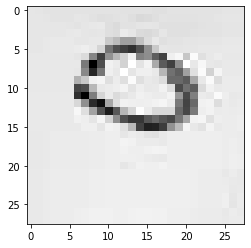

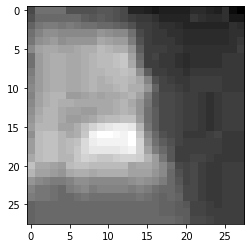

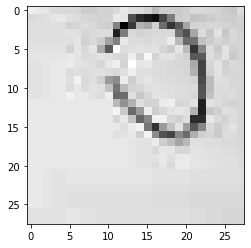

In [70]:
for field in fieldDict.values():
    fieldImg = field.numpy().reshape(28, 28)
    plt.imshow(fieldImg, cmap='gray')
    plt.show()